In [2]:
import torch 
# torch.cuda.empty_cache()
import torchvision
from torchvision import datasets, models
from torchvision.transforms import transforms
from torchvision.transforms import v2
import torch.utils
import torch.utils.data
import torch.utils.data.dataloader
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import json
import shutil
from config import *

from torch.utils.tensorboard import SummaryWriter
loss_writer = SummaryWriter("resnet/loss")
acc1_writer = SummaryWriter("resnet/top1")
acc5_writer = SummaryWriter("resnet/top5")

Using cuda device


In [3]:
import torch 
from torchvision.transforms import transforms
from torchvision.transforms import v2
import json
from torchvision import datasets, models
from torch.utils.data import DataLoader
import torch.optim as optim
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# torch.set_default_device(device)
print(f"Using {device} device")


### config 
train_dir = 'C:\\localsrc\\python\\AlexNet-PyTorch\\data\\ImageNet_1K\\train'
val_dir = 'C:\\localsrc\\python\\AlexNet-PyTorch\\data\\ImageNet_1K\\val'

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

trans_train = v2.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

trans_val = v2.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

config_batch_sz = 80
config_epochs = 100
config_show_frequency = 100
config_lr = 0.001
config_num_workers = 4
config_start_epoch = 0


### turn synset to json label
# import json
# import os
# from nltk.corpus import wordnet as wn
# import nltk
# nltk.download('wordnet')
# folder_names = [folder for folder in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, folder))]
# label_dict = {}

# for idx, i in enumerate(folder_names):
#     synset = wn.synset_from_pos_and_offset('n', int(i[1:]))
#     print(synset.lemma_names())
#     print(synset.definition())
#     print('------------------')
#     label_dict[idx] = synset.lemma_names()[0]

# with open('label_dict.json', 'w') as f:
#     json.dump(label_dict, f)



label_dict = json.load(open('label_dict.json', 'r'))


train_dataset = datasets.ImageFolder(train_dir,trans_train)
val_dataset = datasets.ImageFolder(val_dir, trans_val)

train_dl = DataLoader(train_dataset, batch_size=config_batch_sz, shuffle=True, pin_memory=True, num_workers=config_num_workers)
val_dl = DataLoader(val_dataset, batch_size=config_batch_sz, shuffle=False, pin_memory=True, num_workers=config_num_workers)

Using cuda device


In [4]:
class BottleNeckBlock(nn.Module):
    expansion = 4
    
    def __init__(
        self, 
        in_channels,
        out_channels,
        stride, 
        downsample,
        # base_channels = 64
        ) -> None:
        
        super().__init__()
        self.stride = stride
        self.in_channels = in_channels # The input channels of a block, will be 4 times as large as output or only twice if the next block has a stride of 2
        self.out_channels = out_channels # actual out channels of the block will be out_channels * expansion
        self.downsample = downsample # only at the first block of before the downsampling
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels = out_channels, out_channels = out_channels * self.expansion, kernel_size = 1, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(out_channels * 4),
        )
        
    def forward(self, x):
        identity = x.clone()
        x = self.block(x)
        
        if self.downsample is not None:
            # print("ok")
            identity = self.downsample(identity)
        
        # print(f'x= {x.shape}', f'identity= {identity.shape}')

        x = torch.add(x, identity)
        x = F.relu(x)
        
        return x

class Resnet50(nn.Module):
    def __init__(self, resBlock, layer_list, num_classes, num_input_channels = 3):
        super().__init__()
        self.in_channels = 64
        self.base_channels = num_input_channels
        
        self.layer = nn.Sequential(
            nn.Conv2d(self.base_channels, self.in_channels, 7, 2, 3, bias = False),
            nn.BatchNorm2d(self.in_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding = 1),
            self._make_layer(BottleNeckBlock, 64, layer_list[0], 1),
            self._make_layer(BottleNeckBlock, 128, layer_list[1], 2),
            self._make_layer(BottleNeckBlock, 256, layer_list[2], 2),
            self._make_layer(BottleNeckBlock, 512, layer_list[3], 2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512 * resBlock.expansion, num_classes, True)
        )
        self._weight_init()
    
    def _weight_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # print("inited")
                nn.init.kaiming_normal_(m .weight, mode= "fan_out", nonlinearity= "relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def _make_layer(
        self, 
        block_type: BottleNeckBlock,
        planes: int,
        blocks_num: int,
        stride,
    ) -> nn.Sequential:
        down_sample = None
        if stride != 1 or self.in_channels != planes * block_type.expansion:
            down_sample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes * block_type.expansion, 1, stride),
                nn.BatchNorm2d(planes * block_type.expansion),
            )
        
        layers = [
            block_type(self.in_channels, planes, stride,down_sample)
        ]
        
        self.in_channels = planes * block_type.expansion
        for _ in range(1, blocks_num):
            layers.append(
                block_type(self.in_channels, planes, 1, None)
            )
        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.layer(x)
        return x
        
        
        
        
        
            
            
            
            
        

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)
    
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [6]:
def adjust_learning_rate(optimizer, epoch, config_lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = config_lr * (0.1 ** (epoch // 34))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.reshape(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def train_one_epoch(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}]".format(epoch))
    
    adjust_learning_rate(optimizer, epoch, config_lr)
    end_time = time.time()
    for i, (inputs, labels) in enumerate(train_loader):
         
        
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        data_time.update(time.time() - end_time)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # print("after forward pass", torch.cuda.memory_allocated() / 1073741824)
        acc1, acc5 = accuracy(outputs, labels, topk=(1,5))
        top1.update(acc1.item(), inputs.size(0))
        top5.update(acc5.item(), inputs.size(0))
        losses.update(loss.item(), inputs.size(0))
        # zero_grad the gradient
        optimizer.zero_grad()
        # compute the gradient 
        loss.backward()
        # print("after backward pass", torch.cuda.memory_allocated() / 1073741824)
        # adjust the learning rate
        optimizer.step()
        # print("after optimizer step", torch.cuda.memory_allocated() / 1073741824)
        if i % config_show_frequency == 0:
            progress.display(i)
            
            
        batch_time.update(time.time() - end_time)
        end_time = time.time()
    
    loss_writer.add_scalar(f"train loss", losses.avg, (epoch))
    acc1_writer.add_scalar(f"train accuracy", top1.avg, (epoch))
    acc5_writer.add_scalar(f"train accuracy", top5.avg, (epoch))

    
    
    


def val(val_loader, model, criterion, optimizer, epoch):

    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    end_time = time.time()
    progress = ProgressMeter(
    len(val_loader),
    [batch_time, data_time, losses, top1, top5],
    prefix="Epoch: [{}]".format(epoch))
    with torch.no_grad():
        
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            data_time.update(time.time() - end_time)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc1, acc5 = accuracy(outputs, labels, topk=(1,5))
            top1.update(acc1.item())
            top5.update(acc5.item())
            losses.update(loss.item(), inputs.size(0))

            if(i % config_show_frequency == 0):
                progress.display(i)
            batch_time.update(time.time() - end_time)
            end_time = time.time()
    
    progress.display(len(val_loader))
    acc1_writer.add_scalar('test accuracy', top1.avg, epoch)
    acc5_writer.add_scalar('test accuracy', top5.avg, epoch)
    loss_writer.add_scalar('test loss', losses.avg, epoch)
    return (top1.avg, top5.avg)

def main_worker():
    # starting_mem = torch.cuda.memory_allocated()
    # print("beginning mem: ", starting_mem)
    best_acc1 = 0
    model = Resnet50(BottleNeckBlock, layer_list=[3,4,6,3],num_classes=1000, num_input_channels=3)
    # model.features = torch.nn.DataParallel(model.features)
    model.cuda()    
    # print("after model to device", torch.cuda.memory_allocated() / 1073741824)
    optimizer = optim.SGD(model.parameters(), lr = config_lr, momentum=0.9, weight_decay=5e-4)
    
    ### ok criterion also need to be in device
    criterion = nn.CrossEntropyLoss().to(device)
    # print("before train", torch.cuda.memory_allocated() / 1073741824)
    for epoch in range(config_start_epoch, config_epochs):
        
        model.train()
        
        train_one_epoch(train_dl, model, criterion, optimizer, epoch)
        
        model.eval()
        
        acc1, acc5 = val(val_dl, model, criterion, optimizer, epoch)
        
        print("top1:", acc1, " top5:", acc5)
        
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'acc1': acc1,
            'acc5': acc5,
            'optimizer_state_dict': optimizer.state_dict(),
        }, "ResNetcheckpoint.pth.tar")
        
        if acc1 > best_acc1:
            shutil.copy("ResNetcheckpoint.pth.tar", "bestResNet.pth.tar")
        
def main_worker_resume():
    # starting_mem = torch.cuda.memory_allocated()
    # print("beginning mem: ", starting_mem)
    model = Resnet50(BottleNeckBlock, layer_list=[3,4,6,3],num_classes=1000, num_input_channels=3)
    model.cuda()
    # print("after model to device", torch.cuda.memory_allocated)
    optimizer = optim.SGD(model.parameters(), lr = config_lr, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    if os.path.isfile("ResNetcheckpoint.pth.tar"):
        print("=> loading checkpoint '{}'".format("ResNetcheckpoint.pth.tar"))
        checkpoint = torch.load("ResNetcheckpoint.pth.tar")
        config_start_epoch = checkpoint['epoch']
        best_acc1 = checkpoint['acc1']
        best_acc1 = best_acc1
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})"
                .format("resume", checkpoint['epoch']))
        del checkpoint
    else:
        print("=> no checkpoint found at '{}'".format("ResNetcheckpoint.pth.tar"))
        
    criterion = nn.CrossEntropyLoss().to(device)
    for epoch in range(config_start_epoch, config_epochs):
        
        model.train()
        
        train_one_epoch(train_dl, model, criterion, optimizer, epoch)
        
        model.eval()
        
        acc1, acc5 = val(val_dl, model, criterion, optimizer, epoch)
        
        print("top1:", acc1, " top5:", acc5)
        
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'acc1': acc1,
            'acc5': acc5,
            'optimizer_state_dict': optimizer.state_dict(),
        }, "ResNetcheckpoint.pth.tar")
        
        if acc1 > best_acc1:
            shutil.copy("ResNetcheckpoint.pth.tar", "bestResNet.pth.tar")

In [6]:
main_worker()

Epoch: [0][    0/16015]	Time  0.000 ( 0.000)	Data  8.971 ( 8.971)	Loss 7.1432e+00 (7.1432e+00)	Acc@1   0.00 (  0.00)	Acc@5   0.00 (  0.00)
Epoch: [0][  100/16015]	Time  0.474 ( 0.565)	Data  0.000 ( 0.089)	Loss 7.2634e+00 (7.3119e+00)	Acc@1   0.00 (  0.10)	Acc@5   0.00 (  0.50)
Epoch: [0][  200/16015]	Time  0.476 ( 0.521)	Data  0.001 ( 0.045)	Loss 6.9234e+00 (7.1558e+00)	Acc@1   0.00 (  0.14)	Acc@5   0.00 (  0.66)
Epoch: [0][  300/16015]	Time  0.478 ( 0.506)	Data  0.000 ( 0.030)	Loss 6.8894e+00 (7.0808e+00)	Acc@1   0.00 (  0.12)	Acc@5   2.50 (  0.75)
Epoch: [0][  400/16015]	Time  0.476 ( 0.499)	Data  0.000 ( 0.023)	Loss 6.9905e+00 (7.0337e+00)	Acc@1   0.00 (  0.17)	Acc@5   0.00 (  0.83)
Epoch: [0][  500/16015]	Time  0.477 ( 0.494)	Data  0.001 ( 0.018)	Loss 6.7914e+00 (6.9962e+00)	Acc@1   0.00 (  0.20)	Acc@5   0.00 (  0.94)
Epoch: [0][  600/16015]	Time  0.478 ( 0.491)	Data  0.000 ( 0.015)	Loss 6.7024e+00 (6.9613e+00)	Acc@1   1.25 (  0.21)	Acc@5   2.50 (  1.04)
Epoch: [0][  700/16015]	Tim

In [6]:
main_worker_resume()

=> loading checkpoint 'ResNetcheckpoint.pth.tar'
=> loaded checkpoint 'resume' (epoch 19)
Epoch: [19][    0/16015]	Time  0.000 ( 0.000)	Data  9.504 ( 9.504)	Loss 2.0177e+00 (2.0177e+00)	Acc@1  53.75 ( 53.75)	Acc@5  78.75 ( 78.75)
Epoch: [19][  100/16015]	Time  0.495 ( 0.578)	Data  0.001 ( 0.094)	Loss 2.2321e+00 (1.9640e+00)	Acc@1  55.00 ( 53.55)	Acc@5  75.00 ( 79.41)
Epoch: [19][  200/16015]	Time  0.487 ( 0.534)	Data  0.000 ( 0.047)	Loss 1.6869e+00 (1.9606e+00)	Acc@1  56.25 ( 53.55)	Acc@5  81.25 ( 79.41)
Epoch: [19][  300/16015]	Time  0.484 ( 0.517)	Data  0.000 ( 0.032)	Loss 1.9608e+00 (1.9387e+00)	Acc@1  56.25 ( 53.96)	Acc@5  81.25 ( 79.85)
Epoch: [19][  400/16015]	Time  0.485 ( 0.509)	Data  0.000 ( 0.024)	Loss 1.9893e+00 (1.9439e+00)	Acc@1  56.25 ( 54.06)	Acc@5  75.00 ( 79.66)
Epoch: [19][  500/16015]	Time  0.486 ( 0.504)	Data  0.000 ( 0.019)	Loss 1.4863e+00 (1.9385e+00)	Acc@1  67.50 ( 54.11)	Acc@5  87.50 ( 79.77)
Epoch: [19][  600/16015]	Time  0.491 ( 0.501)	Data  0.000 ( 0.016)	Los

In [6]:
main_worker_resume()

=> loading checkpoint 'ResNetcheckpoint.pth.tar'
=> loaded checkpoint 'resume' (epoch 28)
Epoch: [28][    0/16015]	Time  0.000 ( 0.000)	Data  9.420 ( 9.420)	Loss 1.9267e+00 (1.9267e+00)	Acc@1  57.50 ( 57.50)	Acc@5  76.25 ( 76.25)
Epoch: [28][  100/16015]	Time  0.489 ( 0.583)	Data  0.001 ( 0.093)	Loss 1.7166e+00 (1.8052e+00)	Acc@1  63.75 ( 58.09)	Acc@5  80.00 ( 81.03)
Epoch: [28][  200/16015]	Time  0.495 ( 0.537)	Data  0.000 ( 0.047)	Loss 1.6835e+00 (1.7425e+00)	Acc@1  67.50 ( 59.46)	Acc@5  80.00 ( 82.20)
Epoch: [28][  300/16015]	Time  0.480 ( 0.521)	Data  0.000 ( 0.031)	Loss 1.4933e+00 (1.7042e+00)	Acc@1  66.25 ( 60.00)	Acc@5  86.25 ( 82.92)
Epoch: [28][  400/16015]	Time  0.479 ( 0.511)	Data  0.000 ( 0.024)	Loss 1.4824e+00 (1.6716e+00)	Acc@1  61.25 ( 60.42)	Acc@5  85.00 ( 83.40)
Epoch: [28][  500/16015]	Time  0.478 ( 0.504)	Data  0.000 ( 0.019)	Loss 1.5358e+00 (1.6483e+00)	Acc@1  60.00 ( 60.90)	Acc@5  86.25 ( 83.72)
Epoch: [28][  600/16015]	Time  0.476 ( 0.500)	Data  0.000 ( 0.016)	Los

In [6]:
main_worker_resume()

=> loading checkpoint 'ResNetcheckpoint.pth.tar'
=> loaded checkpoint 'resume' (epoch 30)
Epoch: [30][    0/16015]	Time  0.000 ( 0.000)	Data 10.085 (10.085)	Loss 1.3335e+00 (1.3335e+00)	Acc@1  65.00 ( 65.00)	Acc@5  88.75 ( 88.75)
Epoch: [30][  100/16015]	Time  0.445 ( 0.562)	Data  0.000 ( 0.100)	Loss 1.4213e+00 (1.1411e+00)	Acc@1  63.75 ( 71.99)	Acc@5  88.75 ( 90.50)
Epoch: [30][  200/16015]	Time  0.467 ( 0.511)	Data  0.000 ( 0.050)	Loss 1.2218e+00 (1.1577e+00)	Acc@1  70.00 ( 71.38)	Acc@5  91.25 ( 90.33)
Epoch: [30][  300/16015]	Time  0.470 ( 0.496)	Data  0.000 ( 0.034)	Loss 9.9278e-01 (1.1631e+00)	Acc@1  73.75 ( 71.32)	Acc@5  93.75 ( 90.23)
Epoch: [30][  400/16015]	Time  0.469 ( 0.489)	Data  0.000 ( 0.025)	Loss 9.4357e-01 (1.1563e+00)	Acc@1  75.00 ( 71.67)	Acc@5  93.75 ( 90.33)
Epoch: [30][  500/16015]	Time  0.447 ( 0.484)	Data  0.000 ( 0.020)	Loss 1.3244e+00 (1.1583e+00)	Acc@1  68.75 ( 71.66)	Acc@5  86.25 ( 90.25)
Epoch: [30][  600/16015]	Time  0.468 ( 0.479)	Data  0.000 ( 0.017)	Los

=> loading checkpoint 'ResNet-submission/bestResNet.pth.tar'
=> loaded checkpoint 'ResNet-submission/bestResNet.pth.tar' (epoch 41)


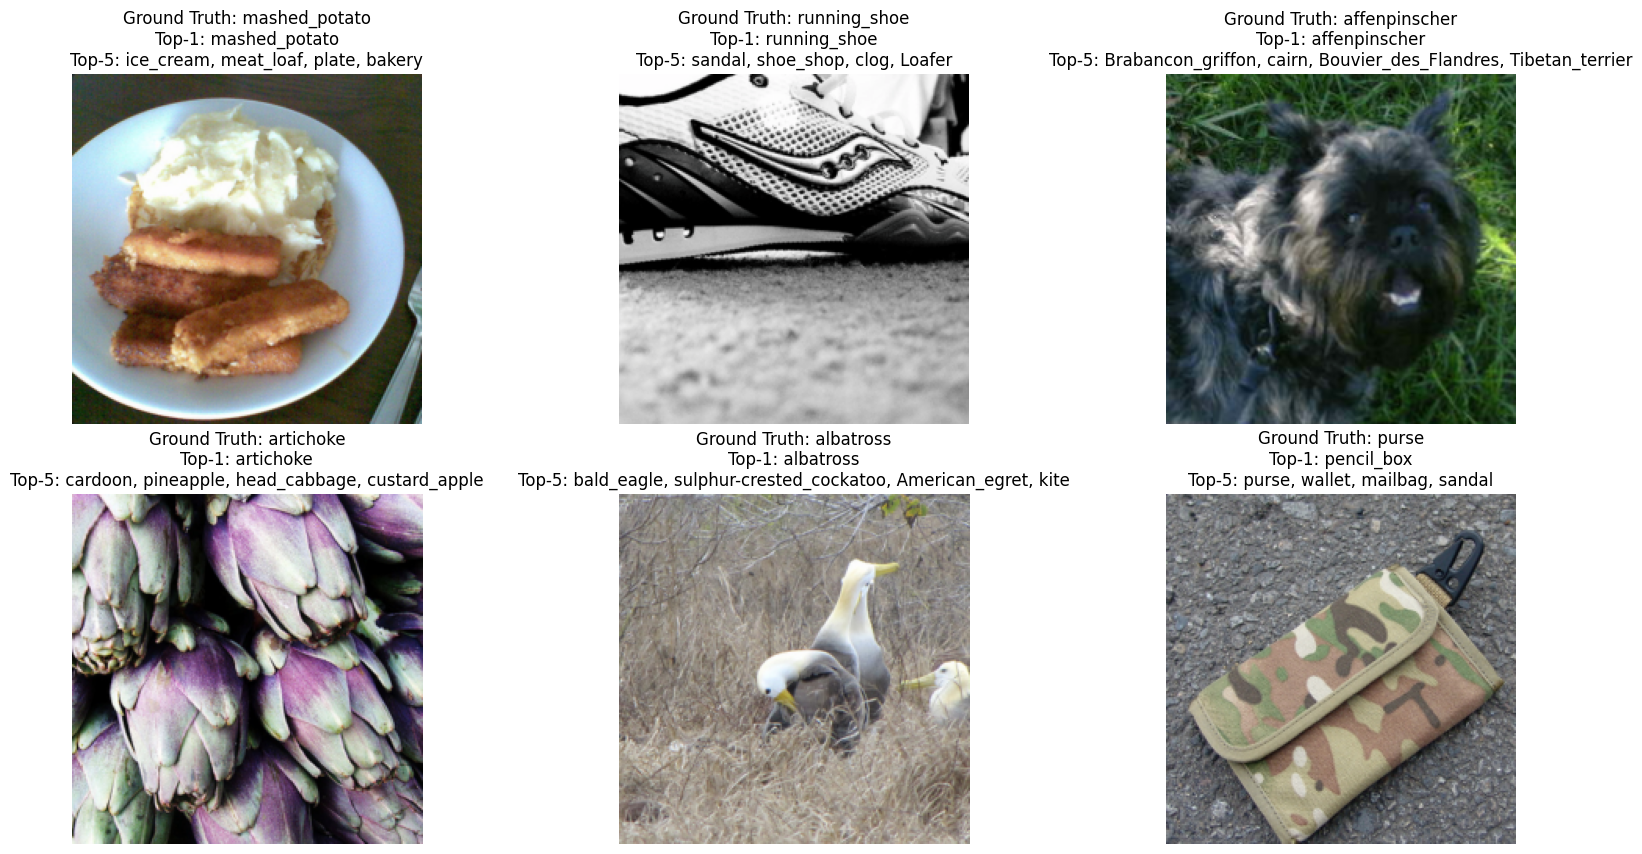

In [9]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import json
import os

# Load label dictionary
with open('label_dict.json', 'r') as f:
    label_dict = json.load(f)

# Load model
model = Resnet50(BottleNeckBlock, layer_list=[3,4,6,3],num_classes=1000, num_input_channels=3)
# model.features = torch.nn.DataParallel(model.features)
model.cuda()

# Load model checkpoint
model_path = "ResNet-submission/bestResNet.pth.tar"
if os.path.isfile(model_path):
    print("=> loading checkpoint '{}'".format(model_path))
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("=> loaded checkpoint '{}' (epoch {})".format(model_path, checkpoint['epoch']))
else:
    print("=> no model found at '{}'".format(model_path))
    exit()

# Set model to evaluation mode
model.eval()

# Define data transforms for validation data loader
trans_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create validation data loader
val_dir = 'C:\\localsrc\\python\\AlexNet-PyTorch\\data\\ImageNet_1K\\val'
val_dataset = datasets.ImageFolder(val_dir, trans_val)
val_dl = DataLoader(val_dataset, batch_size=6, shuffle=True, pin_memory=True, num_workers=config_num_workers)

# Function to decode predictions using label dictionary
def decode_predictions(output, topk=(1, 5)):
    _, indices = torch.topk(output, k=max(topk), dim=1)
    decoded_preds = []
    for idx in indices:
        idx_list = idx.cpu().numpy().tolist()  # Convert tensor to CPU and then to list
        decoded_preds.append([label_dict[str(i)] for i in idx_list])
    return decoded_preds

# Denormalization function
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Function to visualize predictions
def visualize_predictions(model, data_loader, label_dict, topk=(1, 5)):
    # Get a single batch of images and labels
    images, labels = next(iter(data_loader))
    images = images.cuda()
    
    # Run predictions
    with torch.no_grad():
        outputs = model(images)
    predictions = decode_predictions(outputs, topk)
    
    # Denormalize images for visualization
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    images = [denormalize(image.cpu(), mean, std) for image in images]
    
    # Visualize the predictions with ground truth labels
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        plt.subplot(2, len(images)//2, i+1)
        plt.imshow(transforms.ToPILImage()(images[i]))
        ground_truth = label_dict[str(labels[i].item())]
        plt.title(f"Ground Truth: {ground_truth}\nTop-1: {predictions[i][0]}\nTop-5: {', '.join(predictions[i][1:])}")
        plt.axis('off')
    plt.show()

# Visualize predictions
visualize_predictions(model, val_dl, label_dict)
